**FINAL PROJECT**

Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.

This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:

1.   With mask
2.   Without mask
3.   Mask worn incorrectly.




The dataset is provided in the folder Data/images and the labels in Data/labels, obtained from https://www.kaggle.com/datasets/andrewmvd/face-mask-detection. In the following we show how to load the images and labels from these files. 

# Data Paths & Imports

In [1]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
yolo_path = '/content/drive/Shareddrives/Deep Learning Final Project/yolov5/'
data_path = '/content/drive/Shareddrives/Deep Learning Final Project/data/'
path_images = data_path + 'images/'
path_labels = data_path + 'labels/'
results_path = '/content/drive/Shareddrives/Deep Learning Final Project/Results/'

!ls '/content/drive/Shareddrives/Deep Learning Final Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Copy of FinalProject.ipynb'		      FinalProject.ipynb
 CVSlides_ObjectionRecognitionDetection.pdf   results
 data					      yolov5
 DL_FinalProject_Notes.gdoc


Imports

In [2]:
import torch
#from yolov5 import utils
#display = utils.notebook_init()  # checks
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import xml.etree.ElementTree as ET 
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

#faster r-cnn
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.patches as patches

In [3]:
print('Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Using torch 1.11.0+cu113 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


In [4]:
#change to corret directory
%cd drive/Shareddrives/Deep Learning Final Project/yolov5

/content/drive/Shareddrives/Deep Learning Final Project/yolov5


# Install YOLOv5 - **ONLY RUN ONCE!!!!!**

In [ ]:
#clone repository and install requirements
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 2022-6-9 Python-3.7.13 torch-1.11.0+cu113 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.2/107.7 GB disk)


# Data Preparation using pandas

**Display sample of dataset**

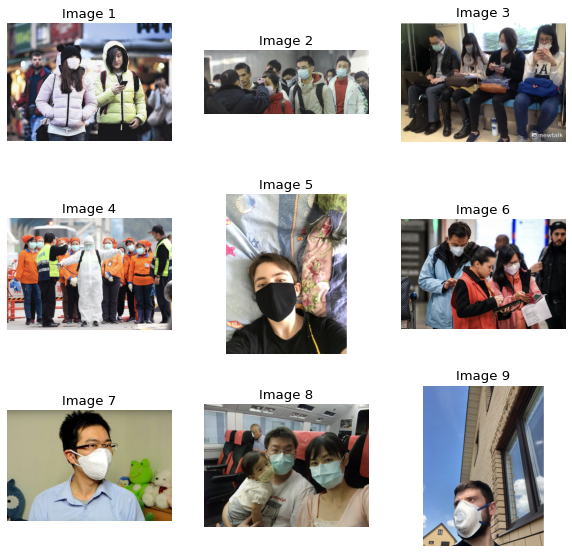

In [ ]:
#printing a sample image

i=0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
filenames = [path_images+'maksssksksss0.png',path_images+'maksssksksss1.png', path_images+'maksssksksss2.png', path_images+'maksssksksss3.png', path_images+'maksssksksss4.png', path_images+'maksssksksss5.png', path_images+'maksssksksss6.png', path_images+'maksssksksss7.png', path_images+'maksssksksss8.png', path_images+'maksssksksss9.png']
for filename in filenames[:9]:
  img = plt.imread(filename)
  ax = list(axes.flatten())[i]
  ax.imshow(img)
  ax.set_title('Image ' + str(i+1))
  ax.axis('off')
  i += 1
plt.show()

Prepare Labels by turning them into pandas Dataframe

In [ ]:
dataset = {
            "file":[],
            "name":[],    
            "width":[],
            "height":[],
            "xmin":[],
            "ymin":[],   
            "xmax":[],
            "ymax":[],
           }

for anno in glob.glob(path_labels+"/*.xml"):
    tree = ET.parse(anno)
    
    for elem in tree.iter():
        if 'size' in elem.tag:
            for attr in list(elem):
                if 'width' in attr.tag: 
                    width = int(round(float(attr.text)))
                if 'height' in attr.tag:
                    height = int(round(float(attr.text)))    

        if 'object' in elem.tag:
            for attr in list(elem):
                
                if 'name' in attr.tag:
                    name = attr.text                 
                    dataset['name']+=[name]
                    dataset['width']+=[width]
                    dataset['height']+=[height] 
                    dataset['file']+=[anno.split('/')[-1][0:-4]] 

                if 'bndbox' in attr.tag:
                    for dim in list(attr):
                        if 'xmin' in dim.tag:
                            xmin = int(round(float(dim.text)))
                            dataset['xmin']+=[xmin]
                        if 'ymin' in dim.tag:
                            ymin = int(round(float(dim.text)))
                            dataset['ymin']+=[ymin]                                
                        if 'xmax' in dim.tag:
                            xmax = int(round(float(dim.text)))
                            dataset['xmax']+=[xmax]                                
                        if 'ymax' in dim.tag:
                            ymax = int(round(float(dim.text)))
                            dataset['ymax']+=[ymax]

In [ ]:
df=pd.DataFrame(dataset)
df.head()

file       name  width  height  xmin  ymin  xmax  ymax
0   maksssksksss10  with_mask    301     400    98   267   194   383
1  maksssksksss108  with_mask    400     225   155    29   180    51
2  maksssksksss108  with_mask    400     225   206    35   228    58
3  maksssksksss108  with_mask    400     225   332    67   346    81
4  maksssksksss108  with_mask    400     225   362    68   376    82

In [ ]:
name_dict = {
    'with_mask': 0,
    'mask_weared_incorrect': 1,
    'without_mask': 2 
}

In [ ]:
df['class'] = df['name'].map(name_dict)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   file    4072 non-null   object
 1   name    4072 non-null   object
 2   width   4072 non-null   int64 
 3   height  4072 non-null   int64 
 4   xmin    4072 non-null   int64 
 5   ymin    4072 non-null   int64 
 6   xmax    4072 non-null   int64 
 7   ymax    4072 non-null   int64 
 8   class   4072 non-null   int64 
dtypes: int64(7), object(2)
memory usage: 286.4+ KB


In [ ]:
np.sort(df.name.unique())


array(['mask_weared_incorrect', 'with_mask', 'without_mask'], dtype=object)

In [ ]:
df.describe()


width       height         xmin         ymin         xmax  \
count  4072.000000  4072.000000  4072.000000  4072.000000  4072.000000   
mean    393.702849   270.123772   182.207024    85.780697   213.356090   
std      35.411593    52.340433   104.471254    52.571821   102.712267   
min     193.000000   156.000000     1.000000     1.000000     8.000000   
25%     400.000000   226.000000    96.000000    49.000000   134.000000   
50%     400.000000   267.000000   177.000000    75.000000   212.000000   
75%     400.000000   281.000000   266.000000   113.000000   292.000000   
max     600.000000   600.000000   569.000000   330.000000   592.000000   

              ymax        class  
count  4072.000000  4072.000000  
mean    120.785609     0.382367  
std      70.355098     0.767117  
min       6.000000     0.000000  
25%      73.000000     0.000000  
50%     103.000000     0.000000  
75%     148.000000     0.000000  
max     495.000000     2.000000

In [ ]:
df['name'].value_counts()/df['name'].count() * 100.

with_mask                79.371316
without_mask             17.608055
mask_weared_incorrect     3.020629
Name: name, dtype: float64

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
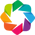

:Bars   [index]   (name)

In [ ]:
import holoviews as hv
hv.extension('bokeh')
color = '#fcba03'
options = dict(width=600, height=400, color=color, tools=['hover'], xlabel='Classes', ylabel='Count', title="Classes Distribution")
hv.Bars(df['name'].value_counts()).opts(**options)

Train and Test Split

In [ ]:
fileNames = [*os.listdir(path_images)]
len(fileNames)

864

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(fileNames, test_size=0.15, shuffle=22)
test, val = train_test_split(test, test_size=0.7, random_state=22)
print("Length of Train =",len(train))
print("-"*30)
print("Length of Valid =",len(val))
print("-"*30)
print("Length of test =", len(test))

Length of Train = 734
------------------------------
Length of Valid = 91
------------------------------
Length of test = 39


# Copy data to /data for Data Loader

In [ ]:
os.mkdir(data_path+'train')
os.mkdir(data_path+'test')
os.mkdir(data_path+'val')

os.mkdir(data_path+'train/images')
os.mkdir(data_path+'test/images')
os.mkdir(data_path+'val/images')

In [ ]:

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(path_images+image)
        img1 = img.resize((640, 480))
        _ = img1.save(data_path+folder_Name+"/images/"+image)

In [ ]:
copyImages(train, "train")
copyImages(test, "test")
copyImages(val, "val")

In [ ]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

# Transfer Learning with Faster R-CNN

In [ ]:
def create_tensor(name):
#  fileNames = [x.split(".")[0] for x in image_list]

#  for name in fileNames:
  data = df[df.file==name]
  boxes = []
  labels = []
        
  for index in range(len(data)):
    row = data.iloc[index]
         
    boxes.append([row["xmin"], row["ymin"], row["xmax"], row["ymax"]])
    labels.append(row["class"])
  boxes = torch.as_tensor(boxes, dtype=torch.float32)
  # Labels 
  labels = torch.as_tensor(labels, dtype=torch.int64)
  # Tensorise image_name
  #name = torch.tensor([name])
  # Annotation is in dictionary format
  target = {}
  target["boxes"] = boxes
  target["labels"] = labels
  #target["image_id"] = name

  return target

In [ ]:
class MaskDataset(object):
    def __init__(self, transforms, folder):
        self.transforms = transforms
        # create sorted list of file names
        self.img_path = data_path+folder+"/images/"
        self.imgs = list(sorted(os.listdir(self.img_path)))
        self.imgs = [x.split(".")[0] for x in self.imgs]
        

    def __getitem__(self, idx):
        # load images ad masks
        img = Image.open(self.img_path+self.imgs[idx]+".png").convert("RGB")
        #Generate Label
        target = create_tensor(self.imgs[idx])
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
dataset = MaskDataset(data_transform, "train")
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, collate_fn=collate_fn)

In [ ]:
num_classes = 3

# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# freeze the backbone 
for p in model.backbone.parameters():
  p.requires_grad = False

# freeze the fc6 layer in roi_heads
for p in model.roi_heads.box_head.fc6.parameters():
  p.requires_grad = False

In [ ]:
model

In [ ]:
num_epochs = 40
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001,  weight_decay=0.0005)

len_dataloader = len(data_loader)

total_loss = []

for epoch in range(num_epochs):
  model.train()
  i = 0    
  epoch_loss = 0
  for imgs, annotations in data_loader:
      i += 1
      imgs = list(img.to(device) for img in imgs)
      annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
      loss_dict = model([imgs[0]], [annotations[0]])
      losses = sum(loss for loss in loss_dict.values())  

      optimizer.zero_grad()
      losses.backward()
      optimizer.step() 
      #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
      epoch_loss += losses
  total_loss.append(epoch_loss)
  print(epoch_loss)

tensor(19.47028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(13.05729, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.59499, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11.17918, device='cuda:0', grad_fn=<AddBackward0>)
tensor(10.63938, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.03049, device='cuda:0', grad_fn=<AddBackward0>)
tensor(9.68866, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.36755, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.05266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.59602, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.03867, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.45985, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.55739, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.86463, device='cuda:0', grad_fn=<AddBackward0>)
tensor(6.90122, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.48729, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8.22275, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.20493, device='cu

In [ ]:
model.eval()

torch.save(model.state_dict(),'frcnn_40TL.pt')

<Figure size 432x288 with 0 Axes>

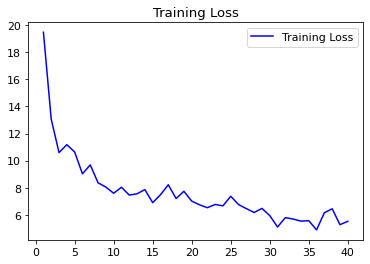

<Figure size 432x288 with 0 Axes>

In [ ]:
epoch_loss = [19.47028, 13.05729, 10.59499, 11.17918, 10.63938, 9.03049, 9.68866, 8.36755, 8.05266, 7.59602, 8.03867, 7.45985, 7.55739, 7.86463, 6.90122, 7.48729, 8.22275, 7.20493, 7.74248, 7.01587, 6.74473, 6.52935, 6.76976, 6.66489, 7.37344, 6.76404, 6.46217, 6.17679, 6.47799, 5.94966, 5.10745, 5.79862, 5.69354, 5.53950, 5.57235, 4.89195, 6.15895, 6.45073, 5.28018, 5.52567]

epochs = range(1, num_epochs + 1)

plt.plot(epochs, epoch_loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.legend()
plt.figure()


In [ ]:
num_classes = 3


# load an instance segmentation model pre-trained pre-trained on COCO
model2 = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# get number of input features for the classifier
in_features = model2.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model2.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


model2.load_state_dict(torch.load('frcnn_10.pt'))

model2.eval()

In [ ]:
#create data loader for test data
testset = MaskDataset(data_transform, "test")
test_loader = torch.utils.data.DataLoader(testset, batch_size=16, collate_fn=collate_fn)

for imgs, annotations in test_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

preds = model(imgs)


In [ ]:
def plot_image(img_tensor, annotation, num):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    box = annotation["boxes"]
    label = annotation["labels"]

    for i in range(len(box)):
        xmin, ymin, xmax, ymax = box[i].cpu().detach().numpy()

        lab = label[i].cpu().detach().numpy()
        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none', label = lab)

        # Add the patch to the Axes
        ax.add_patch(rect)
    plt.legend()
    plt.show()

Prediction
Target
Prediction
Target
Prediction
Target
Prediction
Target
Prediction
Target
Prediction
Target


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


Prediction
Target
Prediction
Target
Prediction
Target
Prediction
Target
Prediction
Target
Prediction


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
No handles with labels found to put in legend.


Target
Prediction
Target
Prediction
Target
Prediction
Target
Prediction
Target


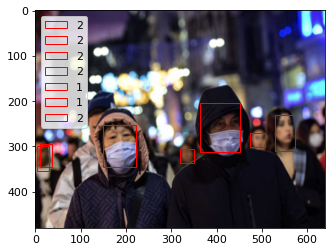

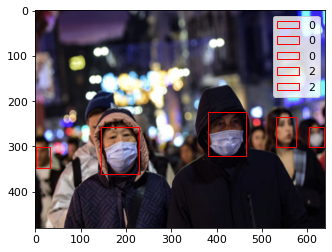

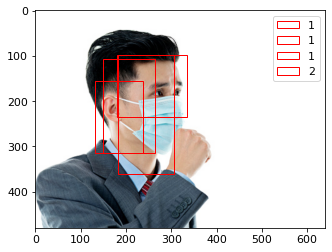

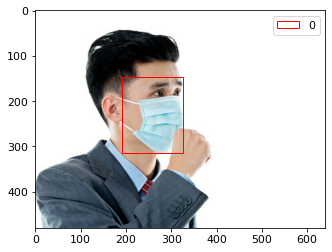

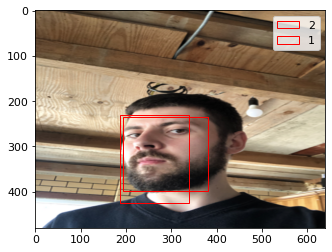

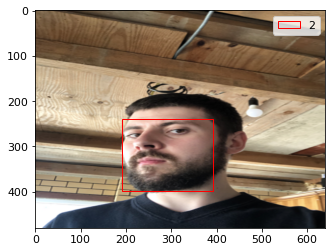

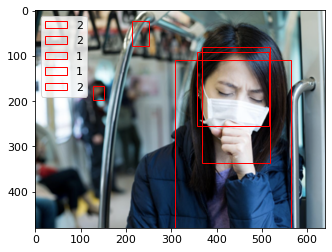

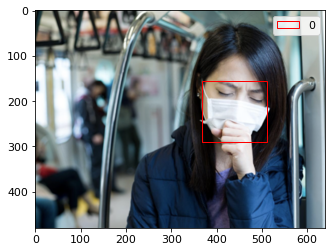

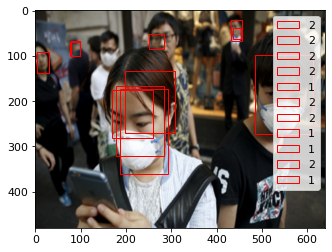

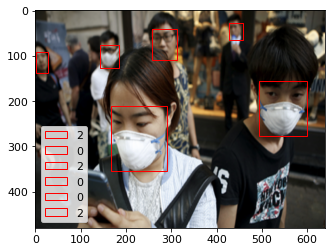

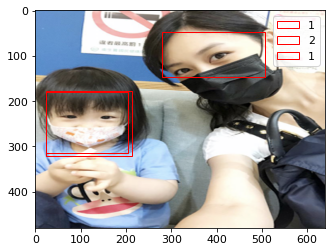

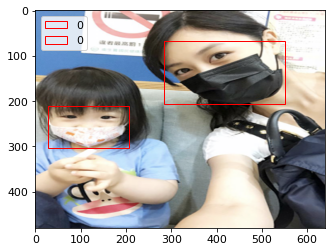

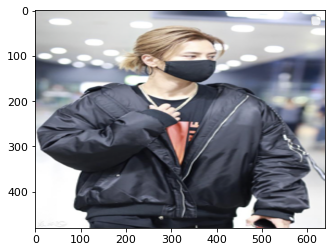

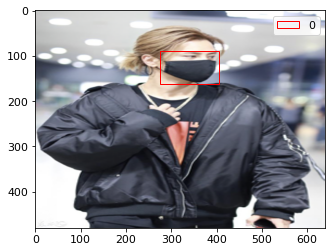

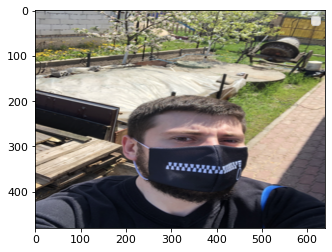

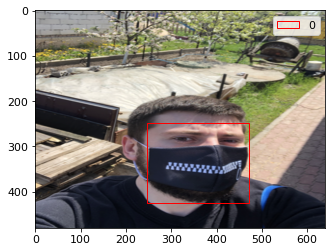

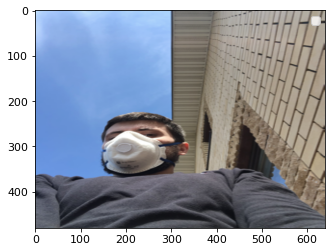

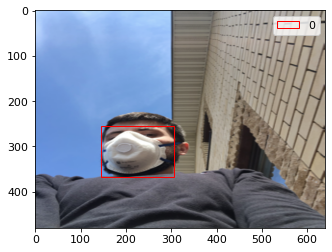

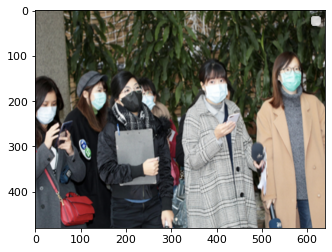

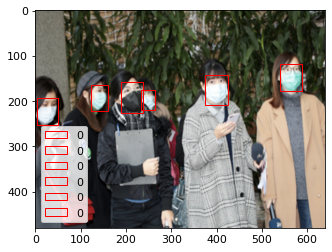

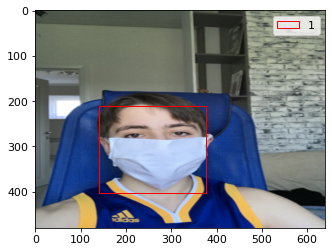

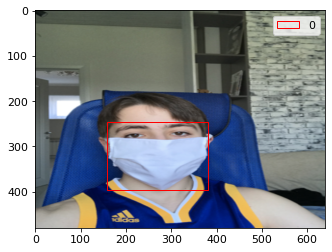

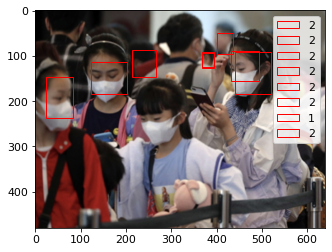

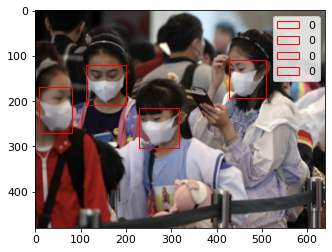

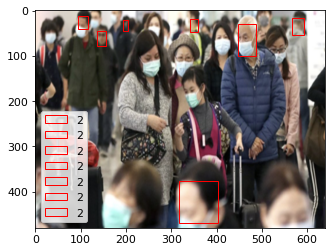

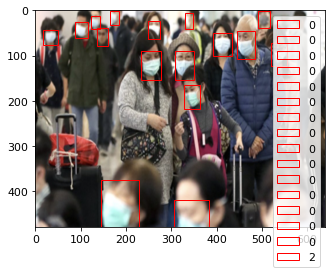

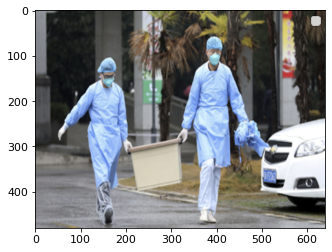

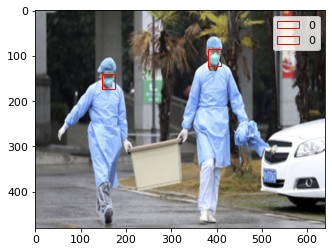

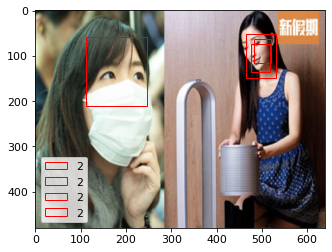

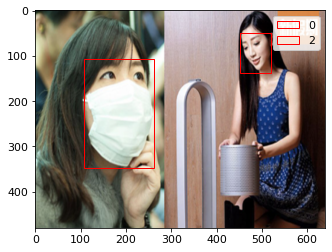

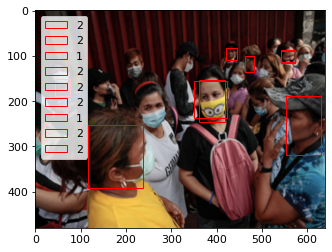

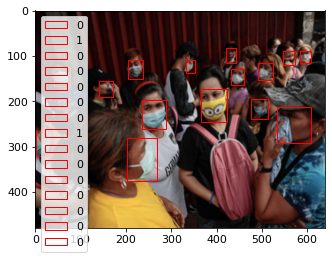

In [ ]:
for i in range(len(imgs)):

  print("Prediction")
  plot_image(imgs[i], preds[i], i)
  print("Target")
  plot_image(imgs[i], annotations[i], i)

# Copy data to yolov5


In [ ]:
os.mkdir(yolo_path+'data/train')
os.mkdir(yolo_path+'data/test')
os.mkdir(yolo_path+'data/val')

os.mkdir(yolo_path+'data/train/images')
os.mkdir(yolo_path+'data/train/labels')
os.mkdir(yolo_path+'data/test/images')
os.mkdir(yolo_path+'data/test/labels')
os.mkdir(yolo_path+'data/val/images')
os.mkdir(yolo_path+'data/val/labels')

In [ ]:
from PIL import Image

def copyImages(imageList, folder_Name):
    for image in imageList:
        img = Image.open(path_images+image)
        img1 = img.resize((640, 480))
        _ = img1.save(yolo_path+"/data/"+folder_Name+"/images/"+image)
        

In [ ]:
copyImages(train, "train")
copyImages(test, "test")
copyImages(val, "val")

Labels from pandas dataframe to .txt

In [ ]:
df['xmax'] = (640/df['width'])*df['xmax']
df['ymax'] = (480/df['height'])*df['ymax']
df['xmin'] = (640/df['width'])*df['xmin']
df['ymin'] = (480/df['height'])*df['ymin']

df[['xmax', 'ymax', 'xmin', 'ymin']] = df[['xmax', 'ymax', 'xmin', 'ymin']].astype('int64')

df['x_center'] = (df['xmax']+df['xmin'])/(2*640)
df['y_center'] = (df['ymax']+df['ymin'])/(2*480)
df['box_height'] = (df['xmax']-df['xmin'])/(640)
df['box_width'] = (df['ymax']-df['ymin'])/(480)

In [ ]:
df = df.astype('string')

def create_labels(image_list, data_name):
    fileNames = [x.split(".")[0] for x in image_list]

    for name in fileNames:
        data = df[df.file==name]
        box_list = []
        
        for index in range(len(data)):
            row = data.iloc[index]
            box_list.append(row['class']+" "+row["x_center"]+" "+row["y_center"]\
                        +" "+row["box_height"]+" "+row["box_width"])
            
        text = "\n".join(box_list)
        with open(yolo_path+"data/"+data_name+"/labels/"+name+".txt", "w") as file:
            file.write(text)    

In [ ]:
create_labels(train, "train")
create_labels(test, "test")
create_labels(val, "val")

# yolov5s Model Data Preparation

In [ ]:
#make sure YOLOv5 is not out of date
#!git pull

In [ ]:
yaml_text = """train: data/train/images
val: data/val/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']"""

In [ ]:
with open(yolo_path+"data/data.yaml", 'w') as file:
    file.write(yaml_text)

In [ ]:
%cat  data/data.yaml

train: data/train/images
val: data/val/images

nc: 3
names: ['with_mask', 'mask_weared_incorrect', 'without_mask']

# Fine-tuning yolov5s

In [ ]:
 # train yolov5s on custom data for 100 epochs
# time its performance
from datetime import datetime

start = datetime.now()
!python train.py --img 640 --batch 16 --epochs 6 --data data/data.yaml --weights yolov5s.pt --name yolov5s_FT6 --cache
end = datetime.now()

print("Runtime =",end-start)

train: weights=yolov5s.pt, cfg=, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=6, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_FT6, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
fatal: cannot change to '/content/drive/Shareddrives/Deep': No such file or directory
YOLOv5 🚀 2022-6-9 Python-3.7.13 torch-1.11.0+cu113 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=

In [ ]:
#plot the loss
from utils.plots import plot_results 
plot_results(yolo_path+'runs/train/yolov5s_FT6/results.csv')  # plot 'results.csv' as 'results.png'

AssertionError: ignored

In [ ]:
#example classified images
img = plt.imread('runs/train/yolov5s_FT6/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

**Testing**

In [ ]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_FT62/weights/best.pt --name yolov5s_FT6 --conf 0.4

detect: weights=['runs/train/yolov5s_FT62/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5s_FT6, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/drive/Shareddrives/Deep': No such file or directory
YOLOv5 🚀 2022-6-9 Python-3.7.13 torch-1.11.0+cu113 CPU

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients
image 1/130 /content/drive/Shareddrives/Deep Learning Final Project/yolov5/data/test/images/maksssksksss101.png: 480x640 1 with_mask, Done. (0.272s)
image 2/130 /content/drive/Shareddrives/Deep Learning Final Project/yolov5/data/test/images/maksssksksss104.png: 480x640 4 with_masks, 6 without_masks, Done.

In [ ]:
i=0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
filenames = ['maksssksksss7.png','maksssksksss18.png','maksssksksss19.png','maksssksksss28.png','maksssksksss45.png', 'maksssksksss47.png', 'maksssksksss51.png', 'maksssksksss54.png', 'maksssksksss56.png', 'maksssksksss79.png']
for filename in filenames[:9]:
  img = plt.imread(yolo_path+'runs/detect/yolov5s_FT6/'+filename)
  ax = list(axes.flatten())[i]
  ax.imshow(img)
  ax.set_title('Image ' + str(i+1))
  ax.axis('off')
  i += 1
plt.show()

# Transfer Learning with yolov5s

In [5]:
 # train yolov5s on custom data for 100 epochs
# time its performance
from datetime import datetime

start = datetime.now()
!python train.py --freeze 10 --img 640 --batch 32 --epochs 60 --data data/data.yaml --weights yolov5s.pt --name yolov5s_TL60 --cache
end = datetime.now()

print("Runtime =",end-start)

train: weights=yolov5s.pt, cfg=, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=60, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_TL60, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[10], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 3 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
fatal: cannot change to '/content/drive/Shareddrives/Deep': No such file or directory
YOLOv5 🚀 2022-6-9 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momen

In [6]:
#plot the loss
from utils.plots import plot_results 
plot_results(yolo_path+'runs/train/yolov5s_TL60/results.csv')  # plot 'results.csv' as 'results.png'

In [7]:
#example classified images
img = plt.imread('runs/train/yolov5s_TL60/train_batch0.jpg')
plt.figure(figsize=(20,15))
plt.imshow(img)
plt.axis('off')
plt.show()

**Testing**

In [8]:
!python detect.py --source data/test/images/ --weight runs/train/yolov5s_TL40/weights/best.pt --name yolov5s_TL60 --conf 0.4

detect: weights=['runs/train/yolov5s_TL40/weights/best.pt'], source=data/test/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=yolov5s_TL60, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
fatal: cannot change to '/content/drive/Shareddrives/Deep': No such file or directory
YOLOv5 🚀 2022-6-9 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 213 layers, 7018216 parameters, 0 gradients
image 1/39 /content/drive/Shareddrives/Deep Learning Final Project/yolov5/data/test/images/maksssksksss110.png: 480x640 10 with_masks, 16 without_masks, Done. (0.011s)
image 2/39 /content/drive/Shareddrives/Deep Learning Final Project/yolov5/data/test/images/maksssksks

In [9]:
i=0
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
filenames = ['maksssksksss7.png','maksssksksss18.png','maksssksksss19.png','maksssksksss28.png','maksssksksss45.png', 'maksssksksss47.png', 'maksssksksss51.png', 'maksssksksss54.png', 'maksssksksss56.png', 'maksssksksss79.png']
for filename in filenames[:9]:
  img = plt.imread(yolo_path+'runs/detect/yolov5s_TL40/'+filename)
  ax = list(axes.flatten())[i]
  ax.imshow(img)
  ax.set_title('Image ' + str(i+1))
  ax.axis('off')
  i += 1
plt.show()

FileNotFoundError: ignored